# Image Stitching using SIFT

Your phone can take a series of photos or a video and convert it into a panoramic image. I'm going to try and recreate that here in this notebook. I have this clean video of a beautiful landscape in Greece (courtesy of my brother-in-law), which I'll convert into a panorama using SIFT.

In [1]:
import cv2
import numpy as np
from anutils import data_path
from anutils.cv import rects, rect, homogenize, unhomogenize, homogenize_1d, unhomogenize_1d
from IPython import display as disp
from matplotlib import pyplot as plt
from itertools import accumulate
from operator import matmul, attrgetter
from functools import reduce

# Configuration
fa, fb = figscale = (7, 2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (4 * fa // fb, 3 * fa // fb)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
np.set_printoptions(precision=2, suppress=True)

def disprgb(image):
    rgbim = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgbim)
    plt.show()

def disp_kps(image, keypoints):
    d_img = image.copy()
    cv2.drawKeypoints(d_img, keypoints, d_img)
    disprgb(d_img)

def disp_mtc(img1, kps1, img0, kps0, matches01):
    d_img = cv2.drawMatches(img1, kps1, img0, kps0, 
                            matches01, None, 
                            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    disprgb(d_img)
    

video_file = data_path / 'image-stitching-example.mp4'
frames_path = data_path / 'frames'

disp.Video(str(video_file), embed=True)

First off, we'll split the video into several individual frames that we can stitch together. We'll use ffmpeg to do this (so this notebook requires ffmpeg)

In [2]:
%%bash

TIME_START=1.5
FRAMES_DIR=frames
FRAME_RATE=.5
EXTENSION="jpeg"

pushd ../../data

if [ -d $FRAMES_DIR ]; then
    rm -f $FRAMES_DIR/*.$EXTENSION
else
    mkdir $FRAMES_DIR
fi

ffmpeg -i image-stitching-example.mp4 -ss $TIME_START -r $FRAME_RATE $FRAMES_DIR/image-stitching-example-%02d.$EXTENSION

# for some reason the first frame seems to be duplicated, so we'll remove it and start at 2 \-_-/
rm $FRAMES_DIR/image-stitching-example-01.$EXTENSION

popd

~/Documents/GitHub/andys-notebook/data ~/Documents/GitHub/andys-notebook/notebooks/image-processing-and-computer-vision


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
6ubuntu2~24.04)c 13 (Ubuntu 13.3.0-
  configuration: --prefix=/usr/local --enable-gpl --enable-libx264
  libavutil      59. 39.100 / 59. 39.100
  libavcodec     61. 19.100 / 61. 19.100
1.  7.100 / 61.  7.100
  libavdevice    61.  3.100 / 61.  3.100
.100bavfilter    10.  4.100 / 10.  4
  libswscale      8.  3.100 /  8.  3.100
  libswresample   5.  3.100 /  5.  3.100
    58.  3.100 / 58.  3.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'image-stitching-example.mp4':
  Metadata:
   : isom_brand  
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
vf61.7.100r         : La
  Duration: 00:00:12.01, start: 0.000000, bitrate: 1076 kb/s
  Stream #0:0[0x1](und): Video: h264 (High 10) (avc1 / 0x31637661), yuv420p10le(tv, bt2020nc/bt2020/arib-std-b67, progressive), 1280x720, 1072 kb/s, 29.97 fps, 29.97 tbr, 30k tbn (default)
ata:  Metad
        handler_name    : Core Media Video
        vendor_id       : [0][0][0][0]
   

~/Documents/GitHub/andys-notebook/notebooks/image-processing-and-computer-vision


Next up let's read the first frame in

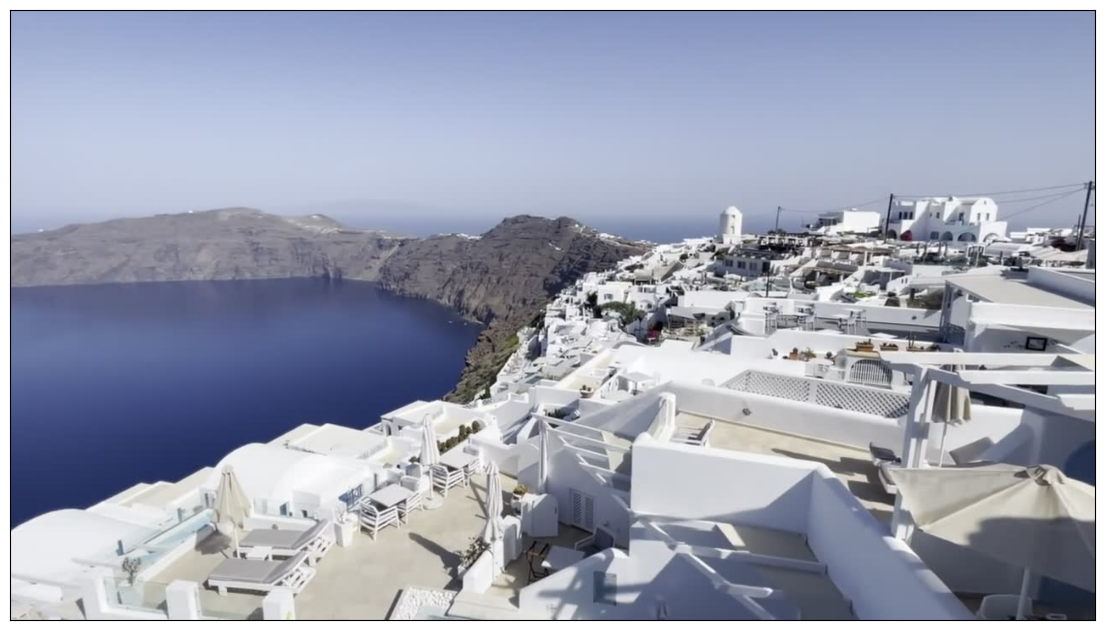

In [3]:
frames = sorted(list(frames_path.glob("*.jpeg")))
first_frame = frames[0]
img0 = cv2.imread(str(first_frame))

disprgb(img0)

We'll then use SIFT to find some keypoints in this image.

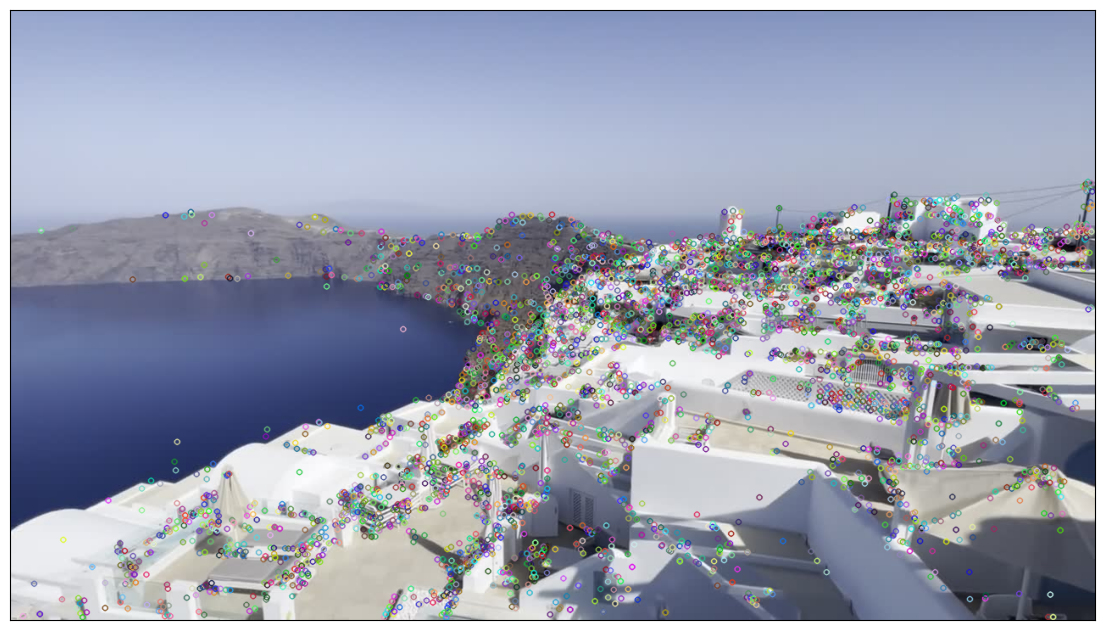

In [4]:
sift = cv2.SIFT.create()

kps0, dsc0 = sift.detectAndCompute(img0, None)

disp_kps(img0, kps0)

Next image! We'll do the same thing except we'll run SIFT for the entire image

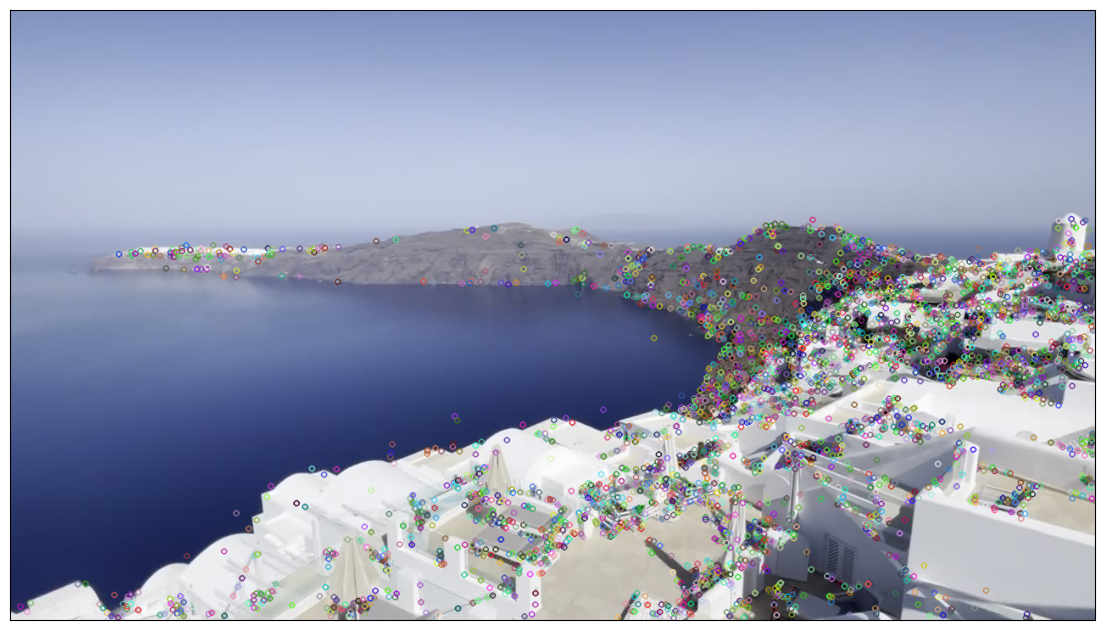

In [5]:
second_frame = frames[1]
img1 = cv2.imread(str(second_frame))

kps1, dsc1 = sift.detectAndCompute(img1, None)

disp_kps(img1, kps1)

Now we'll try to match

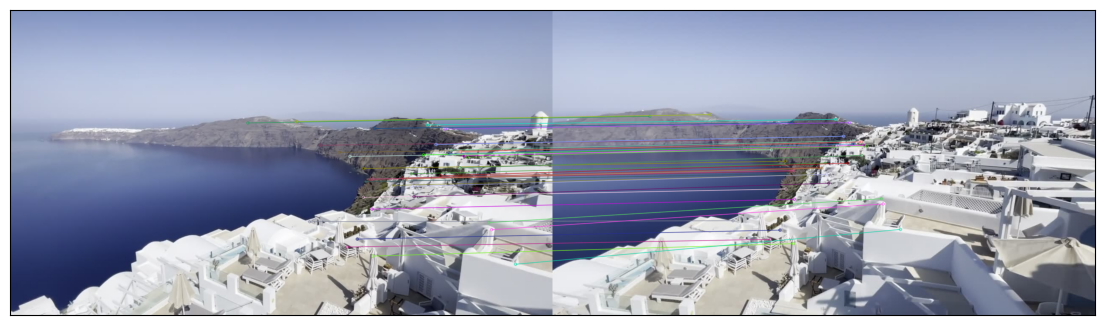

In [6]:
matcher = cv2.BFMatcher()

def match_with_ratio_test(trg_dsc, src_dsc, ratio_threshold=0.45):
    match_groups = matcher.knnMatch(trg_dsc, src_dsc, k=2)
    positive_b = [ m for m in match_groups if m[0].distance > 0 ]
    return [ a for a,b in positive_b if a.distance/b.distance < ratio_threshold ]

matches01 = match_with_ratio_test(dsc1, dsc0, 0.25)

disp_mtc(img1, kps1, img0, kps0, matches01)

From these matches, we can compute a perspective transformation (a homography) We'll use RANSAC and opencv's `findHomography` function

In [7]:
def homography_from_matches(matches, kps1, kps0):
    dst_points = np.array([ kps0[m.trainIdx].pt for m in matches ])
    src_points = np.array([ kps1[m.queryIdx].pt for m in matches ])
    M,_ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
    return M

M10 = homography_from_matches(matches01, kps1, kps0)
M10

array([[    3.1 ,     0.21, -1347.91],
       [    0.43,     2.39,  -393.69],
       [    0.  ,     0.  ,     1.  ]])

Finally, warp our new image and stitch it with our original one

[[   1.      0.   1347.91]
 [   0.      1.    393.69]
 [   0.      0.      1.  ]]


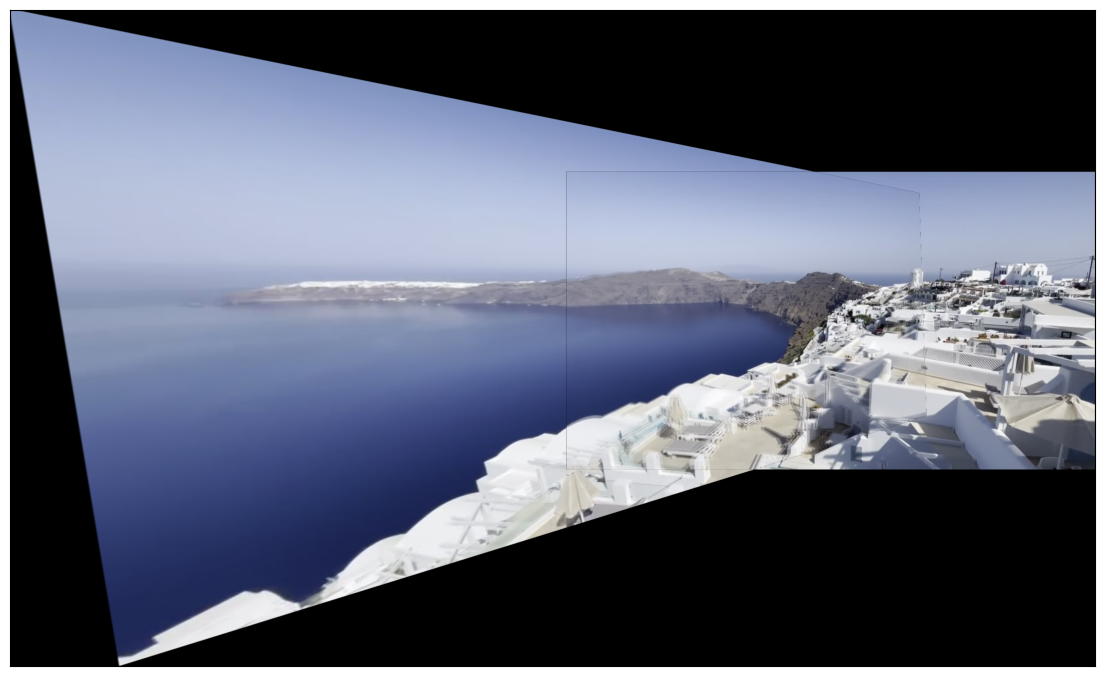

In [8]:
# == IMAGE TRANSFORMATION ==

def transform(points, M):
    h_points = homogenize(points)
    h_trns_points = M @ h_points
    trns_points = unhomogenize(h_trns_points)
    return trns_points

def translate(p):
    return np.array([
        [1,0,p[0]],
        [0,1,p[1]],
        [0,0,1]
    ])

# == BOUNDING BOX ==

def image_box(img):
    iy,ix = img.shape[:2]
    tl = np.array([0,0])
    br = np.array([ix,iy])
    return (tl, br)

def bounding_box(points):
    tl = points.min(axis=0)
    br = points.max(axis=0)
    return (tl, br)

def box_dimensions(tl, br):
    return np.ceil(br - tl).astype(np.int32)

# == COMBINING IMAGES TOGETHER ==

def intersects(a, b):
    return np.all((a > 0) & (b > 0), axis=2)

def union_box(box_1, box_2):
    tl1, br1 = box_1
    tl2, br2 = box_2
    tl_un = np.fmin(tl1, tl2)
    br_un = np.fmax(br1, br2)
    return (tl_un, br_un)

def union_image(img1, img0):
    rescale = np.ones(img1.shape[:2], np.uint8)
    rescale += np.where(intersects(img0, img1), np.uint8(1), np.uint8(0))
    rescale = rescale[:,:,np.newaxis]
    stitched = np.array([img0, img1], dtype=np.int16)
    return (stitched.sum(axis=0) // rescale).astype(np.uint8)

# == MAIN CODE ==

# Transform bounding box 
# to find new dimensions
# and the correction factor
iy1,ix1 = img1.shape[:2]
bnd_box1 = rect(ix1, iy1)
t_box1 = transform(bnd_box1, M10)
t_tl1, _ = t_bbox1 = bounding_box(t_box1)
T1 = translate(-t_tl1)
print(T1)

# Find dimensions of the union of both images
img_box0 = image_box(img0)
s_bbox10 = union_box(t_bbox1, img_box0)
s_dim10 = box_dimensions(*s_bbox10)

# Warp second image to match first.
# Also translate first to compensate for correction
t_img0 = cv2.warpPerspective(img0, T1, s_dim10)
t_img1 = cv2.warpPerspective(img1, T1 @ M10, s_dim10)
stitched10 = union_image(t_img1, t_img0)

disprgb(stitched10)

Now for the next frame, we need to attach the frame image to the previous image. However, in order to stitch the image to the full panorama, we need to make _two_ transformations: one to warp the third frame to match the second frame, and one to match the third and second frame to the first frame. So we'll figure out how to do this before we go do the full frame

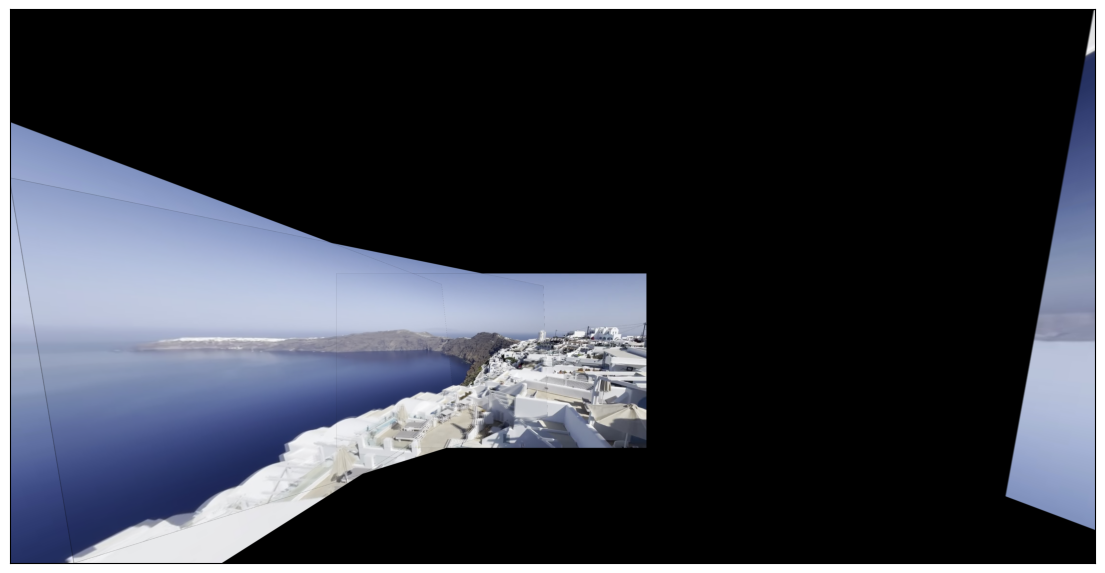

In [9]:
# Load third image
third_frame = frames[2]
img2 = cv2.imread(str(third_frame))

# Find homography
kps2, dsc2 = sift.detectAndCompute(img2, None)
matches = match_with_ratio_test(dsc2, dsc1)
M21 = homography_from_matches(matches, kps2, kps1)

imgs = [img0, img1, img2]
mats = [M10, M21]

def transform_and_stitch(imgs, mats):
    # Accumulate matrix operations
    mats = np.array(list(accumulate(mats, matmul, initial=np.eye(3))))
    
    # Compute final image size and compensatory translate
    tidx = (0,2,1)
    im_sizes = np.array(list(map(attrgetter('shape'), imgs)))
    im_sizes = im_sizes[:,[1,0]]
    im_boxes = rects(im_sizes)
    im_hboxes = np.apply_along_axis(homogenize_1d, 2, im_boxes)
    im_hboxes = np.transpose(im_hboxes, tidx)
    im_thboxes = np.matmul(mats, im_hboxes)
    im_thboxes = np.transpose(im_thboxes, tidx)
    im_tboxes = np.apply_along_axis(unhomogenize_1d, 2, im_thboxes)
    im_itl = im_tboxes.min(axis=(0,1))
    im_ibr = im_tboxes.max(axis=(0,1))
    C = translate(-im_itl)
    i_dims = np.ceil(im_ibr - im_itl).astype(np.int32)
    
    # Compute transformations on images and stitch together
    return reduce(union_image, [
        cv2.warpPerspective(img, C @ M, i_dims)
        for img, M in zip(imgs, mats)
    ])

stitched = transform_and_stitch(imgs, mats)
disprgb(stitched)

So now we have some way of stitching more than two images together, let's see what happens if we do all of them...

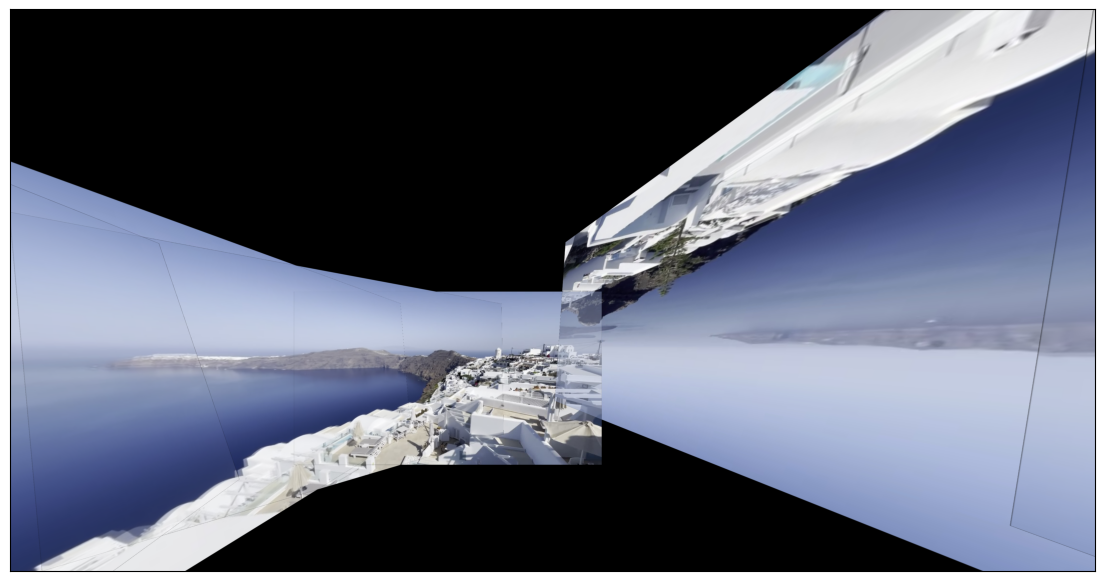

In [10]:
frame_limit = 4

# Get indeces for pairs of images
frame_limit = min(frame_limit, len(frames)) if frame_limit > 0 else len(frames)
pairs = np.arange(frame_limit)
pairs = np.hstack((pairs[:-1,np.newaxis], pairs[1:,np.newaxis]))
s_frames = frames[:frame_limit]

# Load images
imgs = [ cv2.imread(f) for f in s_frames ]

# Compute keypoints
kpdscs = [ sift.detectAndCompute(img, None) for img in imgs ]

# Compute homographies for images
mats = []
for iA,iB in pairs:
    kpsB, dscB = kpdscs[iB]
    kpsA, dscA = kpdscs[iA]
    matches = match_with_ratio_test(dscB, dscA)
    matBA = homography_from_matches(matches, kpsB, kpsA)
    mats.append(matBA)

# Stitch them together ?
stitched = transform_and_stitch(imgs, mats)
disprgb(stitched)

So it appears we're hitting a snag here... The more images we add, the more distorted they become with the accumulating matrix multiplications... It may matter which image we consider our first one. If we pick the center, the distortions won't accumulate as much around the edges as there'd be less images to handle on each side.